## Intro

In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
!pip install Boruta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3657    0  3657    0     0  11115      0 --:--:-- --:--:-- --:--:-- 11149
100  503k  100  503k    0     0   772k      0 --:--:-- --:--:-- --:--:-- 6921k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3661    0  3661    0     0  17771      0 --:--:-- --:--:-- --:--:-- 17858
100  406k  100  406k    0     0   800k      0 --:--:-- --:--:-- --:--:--  800k
     |████████████████████████████████| 56 kB 2.6 MB/s 


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os
import datetime
import io

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plot
import seaborn as sns
import plotly.express as px

# Ta-lib indicators
import talib
from talib import abstract

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

# Boruta
from boruta import BorutaPy

In [5]:
# Google Drive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
  
  
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
#link = 'https://drive.google.com/file/d/1gCSALWWLbKWPYPtB-aYC38I4XrT8_xjF/view?usp=sharing'
link = 'https://drive.google.com/file/d/1Ox_JfIw6BqhC3KAV_ATwqTStNr5ZmNfe/view?usp=sharing' ## bitcoin price raw 2
file_name = 'bitcoin_price_raw_2.csv'
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file_name)  

data = pd.read_csv(file_name)
data['time'] = pd.DatetimeIndex(data['time']) ## Convert for resample later 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19129 entries, 0 to 19128
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    19129 non-null  datetime64[ns]
 1   open    19129 non-null  float64       
 2   high    19129 non-null  float64       
 3   low     19129 non-null  float64       
 4   close   19129 non-null  float64       
 5   volume  19129 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 896.8 KB


## Exploratory Data Analysis and Visulalisation

In [8]:
data.head()

,time,open,high,low,close,volume
0,2019-11-15 00:00:00,8646.38,8659.41,8610.87,8611.98,1248.453018
1,2019-11-15 01:00:00,8611.99,8627.00,8526.11,8559.96,2567.333631
2,2019-11-15 02:00:00,8557.95,8590.06,8526.11,8538.61,2428.512671
3,2019-11-15 03:00:00,8538.16,8579.99,8517.00,8558.15,1777.637624
4,2019-11-15 04:00:00,8558.13,8571.08,8531.61,8557.45,1010.078664


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
open,19129.0,28247.985951,19657.843873,4131.230000,9405.680000,22307.500000,47182.200000,68635.12000
high,19129.0,28414.103686,19775.670225,4610.000000,9435.000000,22665.350000,47458.920000,69000.00000
low,19129.0,28070.345505,19532.671909,3782.130000,9372.270000,22251.230000,46900.000000,68451.19000
close,19129.0,28249.913520,19657.658048,4130.640000,9407.600000,22571.780000,47182.210000,68633.69000
volume,19129.0,2877.400371,2591.430307,0.060061,1417.388655,2140.963331,3412.240136,47255.50215


In [10]:
# Bitcoin Price Chart
title = 'Bitcoin Price from 11/2019 to 01/2022'
fig = px.line(data , x = 'time' , y = 'close' , title = title)

fig.show()

In [11]:
data_daily = data.resample('D', on = 'time').last().dropna()
data_daily['return'] = data_daily['close'].pct_change()
data_daily['SMA30'] = data_daily['close'].rolling(window = 30).mean()
data_daily.tail(5)

,time,open,high,low,close,volume,return,SMA30
time,,,,,,,,
2022-01-16,2022-01-16 23:00:00,43190.00,43263.15,43048.20,43071.66,526.23528,-0.000293,45931.706333
2022-01-17,2022-01-17 23:00:00,42077.18,42296.14,42049.38,42201.62,668.77575,-0.020200,45777.277667
2022-01-18,2022-01-18 23:00:00,42480.96,42560.91,42334.88,42352.12,771.50621,0.003566,45632.974000
2022-01-19,2022-01-19 23:00:00,41976.89,41989.42,41635.24,41660.01,586.37898,-0.016342,45457.835667
2022-01-20,2022-01-20 00:00:00,41660.00,41860.55,41639.88,41828.24,724.19506,0.004038,45222.447667


In [12]:
# Best Single Day Gain
# citigroup stock split in May 2011, but also JPM day after inauguration.
print(data_daily['return'].idxmax())
print(data_daily['return'].idxmin())
print(data_daily['return'].std())

2021-02-08 00:00:00
2020-03-12 00:00:00
0.03998742440025354


In [13]:
# Bitcoin Returns Chart
title = 'Bitcoin Returns from 11/2019 to 01/2022'
fig = px.line(data_daily , x = 'time' , y = 'return' , title = title)

fig.show()

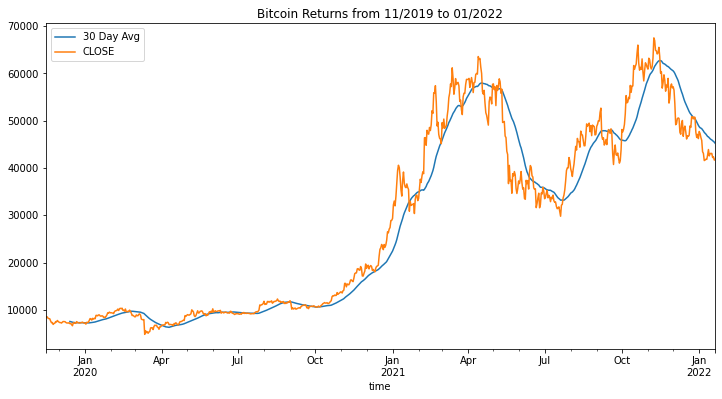

In [14]:
plt.figure(figsize=(12,6))
data_daily['SMA30'].plot(label='30 Day Avg')
data_daily['close'].plot(label='CLOSE')
plt.title(title)
plt.legend()

## Data Imputation

In [15]:
# Check for missing values
data.isna().sum()

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [16]:
# Look for values
data[data['open'].isna()]

,time,open,high,low,close,volume


In [17]:
# Fill missing data
# Forward fill with the last know value
data.fillna(method = 'ffill', inplace = True)

## Feature Engineering

In [18]:
data_copy = data.copy()

In [19]:
data.head()

,time,open,high,low,close,volume
0,2019-11-15 00:00:00,8646.38,8659.41,8610.87,8611.98,1248.453018
1,2019-11-15 01:00:00,8611.99,8627.00,8526.11,8559.96,2567.333631
2,2019-11-15 02:00:00,8557.95,8590.06,8526.11,8538.61,2428.512671
3,2019-11-15 03:00:00,8538.16,8579.99,8517.00,8558.15,1777.637624
4,2019-11-15 04:00:00,8558.13,8571.08,8531.61,8557.45,1010.078664


In [20]:
data = data_copy.copy()

In [21]:
## Overlap Indicators
#talib.abstract.
unit = 24
T = [20, 50, 200];

for t in T:
      data[f'SMA_{t}'] = abstract.SMA(data , timeperiod = t)                    ## Simple Moving Average
      data[f'EMA_{t}'] = abstract.EMA(data , timeperiod = t)                    ## Exponential Moving Average
      data[f'WMA_{t}'] = abstract.WMA(data , timeperiod = t)                    ## Weighted Moving Average
      data[f'DEMA{t}'] = abstract.DEMA(data , timeperiod = t)                   ## Double Exponential Moving Average
      data[f'TEMA{t}'] = abstract.TEMA(data , timeperiod = t)                   ## Triple Exponential Moving Average
      data[f'TRIMA{t}'] = abstract.TRIMA(data , timeperiod = t)                 ## Triangular Moving Average
      data[f'KAMA{t}'] = abstract.KAMA(data , timeperiod = t)                   ## Kaufman Adaptive Moving Average



data[['MAMA', 'FAMA']] = abstract.MAMA (data, fastlimit = .5, slowlimit = .05)

data[['upperband', 'middleband', 'lowerband']] = abstract.BBANDS(data,          ## Number of periods (2 to 100000)
                 timeperiod = 20,
                 nbdevup = 2.0,                                                 ## Deviation multiplier for lower band
                 nbdevdn = 2.0,                                                 ## Deviation multiplier for upper band
                 matype = 1                                                     ## default: SMA
                 )

data['HT_TRENDLINE'] = abstract.HT_TRENDLINE(data)                              ## Hilbert Transform
data['SAR'] = abstract.SAR(data)                                                ## Parabolic SAR

## Momentum Indicators

data['PLUS_DM'] = abstract.PLUS_DM(data, timeperiod = unit)
data['MINUS_DM'] = abstract.MINUS_DM(data, timeperiod = unit)

data['PLUS_DI'] = abstract.PLUS_DI(data, timeperiod = unit)
data['MINUS_DI'] = abstract.MINUS_DI(data, timeperiod = unit)

data['ADX'] = abstract.ADX(data, timeperiod = unit)                             ## Average Directional Movement Index
data['ADXR'] = abstract.ADXR(data, timeperiod = unit)                           ## Average Directional Movement Index Rating
data['APO'] = abstract.APO(data, 
                           fastperiod = 12,
                           slowperiod = 26,
                           matype = 0)                                          ## Absolute Price Oscillator
data['PPO'] = abstract.PPO(data,
                           fastperiod = 12,
                           slowperiod = 26,
                           matype = 0)                                          ## Percentage Price Oscillator
data[['AROON_UP', 'AROON_DWN']] = abstract.AROON(data, timeperiod = unit)       ## Aroon Oscilator Up/ Down
data['AROON_OSC'] = abstract.AROONOSC(data, timeperiod = unit)                  ## Aroon Oscilator Diff
data['BOP'] = abstract.BOP(data)                                                ## Balance Of Power
data['CCI'] = abstract.CCI(data, timeperiod = unit)                             ## Commodity Channel Index

data[['MACD', 'MACDSIG', 'MACDHIST']] = abstract.MACD(data,
                                        fastperiod = 12,
                                        slowperiod = 26,
                                        signalperiod = 9)                       ## Moving Average Convergence/Divergence


data['CMO'] = abstract.CMO(data, timeperiod = unit)                             ## Chande Momementum Oscillator
data['MFI'] = abstract.MFI(data, timeperiod = unit)                             ## Money Flow Index
data['RSI'] = abstract.RSI(data, timeperiod = unit)                             ## Relative Strength Index

data[['FASTK', 'FASTD']] = abstract.STOCHRSI(data,
                              timeperiod= 14,                                   ## 14 hours
                              fastk_period= 14,                                 ## 14 hours
                              fastd_period= 3,                                  ## 3 hours
                              fastd_matype=0)                                   ## Stochastic RSI
     

stoch = abstract.STOCH(data,
                       fastk_period = 14,
                       slowk_period = 3,
                       slowk_matype = 0,
                       slowd_period = 3,
                       slowd_matype = 0)

data['STOCH'] = stoch['slowd'] / stoch['slowk']                                 ## Stochastic Oscillator

data['ULTOSC'] = abstract.ULTOSC(data,
                                 timeperiod1 = 7 ,
                                 timeperiod2 = 14 ,
                                 timeperiod3 = 28)                              ## Ultimate Oscilator

data['WILLR'] = abstract.WILLR(data, timeperiod = unit)                         ## Williams Percent Range


## Volume Indicators

data['AD'] = abstract.AD(data)                                                  ## Chaikin A/D Line


data['ADOSC'] = abstract.ADOSC(data.high, 
                            data.low, 
                            data.close, 
                            data.volume, 
                            fastperiod = 3 , 
                            slowperiod = 10)                                    ## Chaikin A/D Oscilator


data['OBV'] = abstract.OBV(data)                                                ## Order Book Volume

## Volatility Indicators

data['ATR'] = abstract.ATR(data, timeperiod = unit)                             ## Average True Range Indicator


## Create predict variable
data['ret'] = np.log(data['close']).diff().fillna(0)
data['predict'] = np.where(data.ret.shift(-1) > 0, 1, 0)


# Compute lagged returns
cols = []
for lag in range(1 , unit):
    col = f'ret_{lag}'
    data[col] = data.ret.shift(lag)
    cols.append(col)

# Drop nan values
data.dropna(inplace = True)


# Check Data
data.head(10)

,time,open,high,low,close,volume,SMA_20,EMA_20,WMA_20,DEMA20,TEMA20,TRIMA20,KAMA20,SMA_50,EMA_50,WMA_50,DEMA50,TEMA50,TRIMA50,KAMA50,SMA_200,EMA_200,WMA_200,DEMA200,TEMA200,TRIMA200,KAMA200,MAMA,FAMA,upperband,middleband,lowerband,HT_TRENDLINE,SAR,PLUS_DM,MINUS_DM,PLUS_DI,MINUS_DI,ADX,ADXR,...,MACD,MACDSIG,MACDHIST,CMO,MFI,RSI,FASTK,FASTD,STOCH,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,ret,predict,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,ret_10,ret_11,ret_12,ret_13,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
597,2019-12-09 21:00:00,7302.05,7369.23,7291.35,7354.93,1873.687254,7456.1530,7440.026561,7433.017238,7400.717014,7371.246916,7468.060000,7450.494820,7474.5634,7462.588585,7468.175027,7461.745431,7429.603607,7492.747338,7452.166951,7380.88755,7433.224943,7422.678767,7423.611258,7483.102965,7371.317044,7389.278128,7370.562086,7447.644917,7555.120503,7440.026561,7324.932619,7483.407462,7606.808890,166.583600,342.974042,12.518109,25.773164,20.491218,23.057267,...,-33.514746,-17.467313,-16.047433,-17.171619,39.873825,41.414191,28.546960,9.515653,1.086769,35.365703,-78.267905,-31923.369471,-2554.055561,-79588.878357,55.447539,0.007407,0,-0.010038,-0.009484,0.000871,0.003373,-0.001477,-0.015772,0.006004,0.000472,0.002951,-0.001191,0.003135,-0.000586,-0.001280,-0.005685,0.003954,-0.001929,-0.001634,0.001897,0.001956,-0.005121,0.001296,-0.003606,0.001170
598,2019-12-09 22:00:00,7352.61,7356.13,7307.24,7333.25,1136.304163,7448.0110,7429.857365,7421.312190,7385.090883,7353.490234,7461.518727,7444.553600,7471.1712,7457.516484,7462.633325,7451.833199,7416.301517,7491.942585,7449.410865,7380.59570,7432.230167,7422.204762,7421.727263,7479.746643,7372.889115,7388.992187,7368.696482,7445.671206,7555.091080,7429.857365,7304.623649,7480.712437,7586.780356,159.642617,328.683457,12.055929,24.821596,21.079767,23.478618,...,-37.668800,-21.507611,-16.161190,-19.944522,38.346416,40.027739,22.157920,16.901627,0.877859,43.111214,-84.018568,-31850.621832,-2111.925283,-80725.182520,55.174308,-0.002952,1,0.007407,-0.010038,-0.009484,0.000871,0.003373,-0.001477,-0.015772,0.006004,0.000472,0.002951,-0.001191,0.003135,-0.000586,-0.001280,-0.005685,0.003954,-0.001929,-0.001634,0.001897,0.001956,-0.005121,0.001296,-0.003606
599,2019-12-09 23:00:00,7333.02,7359.72,7323.34,7338.64,916.477446,7439.4270,7421.169997,7410.895905,7372.806989,7340.961927,7453.564091,7438.638966,7468.2582,7452.854661,7457.436024,7442.915244,7404.687736,7490.792954,7447.217713,7380.75780,7431.298922,7421.787292,7419.978545,7476.611279,7374.461118,7388.756454,7353.668241,7422.670465,7551.571930,7421.169997,7290.768064,7477.759016,7567.953535,156.580841,314.988313,11.994956,24.129841,21.601092,23.861063,...,-40.064156,-25.218920,-14.845236,-18.911777,40.338451,40.544112,24.950452,25.218444,0.830473,44.393865,-82.588859,-31996.230399,-1785.390597,-79808.705074,54.391212,0.000735,1,-0.002952,0.007407,-0.010038,-0.009484,0.000871,0.003373,-0.001477,-0.015772,0.006004,0.000472,0.002951,-0.001191,0.003135,-0.000586,-0.001280,-0.005685,0.003954,-0.001929,-0.001634,0.001897,0.001956,-0.005121,0.001296
600,2019-12-10 00:00:00,7338.64,7355.00,7312.52,7343.38,1717.514978,7431.6930,7413.761426,7401.748571,7363.301426,7332.591948,7443.925909,7433.975448,7464.7308,7448.561537,7452.538839,7434.887135,7394.570229,7489.305354,7444.582376,7380.85080,7430.424107,7421.415374,7418.350260,7473.673511,7376.023007,7388.554193,7348.524121,7404.133879,7547.637654,7413.761426,7279.885197,7474.017250,7550.256323,150.056640,312.683800,11.601021,24.173881,22.165395,23.970664,...,-41.106167,-28.396369,-12.709798,-17.979612,37.582375,41.010194,27.528383,24.878918,0.974712,43.710201,-81.331565,-31218.335197,-1241.987879,-78091.190096,53.894912,0.000646,1,0.000735,-0.002952,0.007407,-0.010038,-0.009484,0.000871,0.003373,-0.001477,-0.015772,0.006004,0.000472,0.002951,-0.001191,0.003135,-0.000586,-0.001280,-0.005685,0.003954,-0.001929,-0.001634,0.001897,0.001956,-0.005121
601,2019-12-10 01:00

In [22]:
# Check for missing values
data.isna().sum().sort_values()

time         0
ret          0
ATR          0
OBV          0
ADOSC        0
            ..
TRIMA200     0
TEMA200      0
DEMA200      0
lowerband    0
ret_23       0
Length: 87, dtype: int64

## Feature Selection

##### Class Imbalance

In [23]:
# class frequency
c = data['predict'].value_counts()
c

1    9450
0    9082
Name: predict, dtype: int64

In [24]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs['predict'])
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    return {0: w0, 1: w1}

In [25]:
# check class weights
class_weight = cwts(data)
class_weight

{0: 1.0202598546575643, 1: 0.9805291005291006}

In [26]:
# With the calculated weights, both classes gain equal weight
class_weight[0] * c[0], class_weight[1] * c[1]

(9265.999999999998, 9266.0)

##### Split Data

In [27]:
X = data.drop(['predict' , 'time'] , axis = 1)
feature_names = X.columns
X.tail()

,open,high,low,close,volume,SMA_20,EMA_20,WMA_20,DEMA20,TEMA20,TRIMA20,KAMA20,SMA_50,EMA_50,WMA_50,DEMA50,TEMA50,TRIMA50,KAMA50,SMA_200,EMA_200,WMA_200,DEMA200,TEMA200,TRIMA200,KAMA200,MAMA,FAMA,upperband,middleband,lowerband,HT_TRENDLINE,SAR,PLUS_DM,MINUS_DM,PLUS_DI,MINUS_DI,ADX,ADXR,APO,...,CCI,MACD,MACDSIG,MACDHIST,CMO,MFI,RSI,FASTK,FASTD,STOCH,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,ret,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,ret_10,ret_11,ret_12,ret_13,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
19124,41872.45,41961.51,41548.00,41631.40,1063.82649,41887.5455,41921.800178,41902.146619,41902.463224,41948.150452,41844.954182,42077.042105,41941.6390,42041.782059,41910.721459,41772.313923,41789.098872,41906.879769,42139.293329,42736.88035,42604.981452,42520.605011,41894.360023,42147.879915,42891.661817,42582.244631,41962.048979,41929.097292,42577.902478,41921.800178,41265.697878,41857.040838,41300.728889,1786.042903,2089.372656,20.148597,23.570501,19.533498,25.856246,4.495449,...,-58.609684,-13.981150,-9.569591,-4.411559,-9.507107,49.478089,45.246447,32.942706,47.077836,1.171590,48.156262,-68.253846,3.103249e+06,202.391996,681495.64019,369.348080,-0.005805,-0.003129,-0.003470,0.005668,-0.001633,-0.012172,0.007168,0.002298,0.001474,0.012628,-0.001638,0.004941,0.001974,-0.010205,-0.001245,0.001211,0.000135,-0.014931,-0.002038,0.003955,-0.002350,-0.003037,0.002617,0.013919
19125,41629.35,41841.07,41627.25,41712.22,794.85516,41852.1475,41901.840161,41885.448952,41866.285759,41892.948893,41869.219727,42066.399669,41931.1172,42028.858057,41901.724635,41757.540120,41771.889576,41908.153338,42134.970313,42736.93385,42596.098254,42510.409386,41883.752876,42133.043388,42885.620796,42578.598317,41837.134489,41906.106591,42514.103224,41901.840161,41289.577098,41849.015864,41325.896911,1711.624449,2002.315462,19.653906,22.991796,19.045728,25.044375,15.562949,...,-51.239264,-29.415231,-13.538719,-15.876513,-7.412254,47.547204,46.293873,33.873398,38.731569,1.204465,44.415356,-63.047847,3.103086e+06,-1.690684,682290.49535,362.867743,0.001939,-0.005805,-0.003129,-0.003470,0.005668,-0.001633,-0.012172,0.007168,0.002298,0.001474,0.012628,-0.001638,0.004941,0.001974,-0.010205,-0.001245,0.001211,0.000135,-0.014931,-0.002038,0.003955,-0.002350,-0.003037,0.002617
19126,41712.22,41993.98,41637.63,41976.88,703.16640,41834.3010,41908.986812,41897.328238,41883.284562,41916.322201,41895.931364,42065.198849,41928.9854,42026.819702,41903.519255,41764.183264,41786.311045,41909.520754,42134.156710,42738.60825,42589.936878,42502.846661,41878.579445,42126.367570,42879.278806,42575.529017,41844.121765,41904.556971,42483.707574,41908.986812,41334.266050,41852.748434,41350.561573,1793.216763,1918.885651,20.606220,22.050307,18.393214,24.173799,47.434038,...,-13.297165,-20.059765,-14.842928,-5.216837,-0.821755,46.936206,49.589123,47.200087,38.005397,1.040965,52.206369,-41.060920,3.103722e+06,117.236900,682993.66175,362.596171,0.006325,0.001939,-0.005805,-0.003129,-0.003470,0.005668,-0.001633,-0.012172,0.007168,0.002298,0.001474,0.012628,-0.001638,0.004941,0.001974,-0.010205,-0.001245,0.001211,0.000135,-0.014931,-0.002038,0.003955,-0.002350,-0.003037
19127,41976.89,41989.42,41635.24,41660.01,586.37898,41831.9810,41885.274735,41880.729095,41840.566534,41853.261871,41919.979182,42063.114696,41927.7016,42012.435008,41892.971200,41746.277449,41764.154437,41909.184477,42131.906717,42738.23865,42580.683874,42492.114340,41867.243691,42110.504235,42872.584216,42571.537568,41752.065882,41866.434199,42462.411351,41885.274735,41308.138118,41866.797500,41374.732942,1718.499398,1841.322082,19.766744,21.179491,17.770590,23.443826,43.655769,...,-36.439165,-37.778762,-19.430095,-18.348667,-7.882988,47.227995,46.058506,18.137900,33.070462,1.023481,46.404733,-63.292904,3.103218e+06,-5.247229,682407.28277,362.245497,-0.007577,0.006325,0.001939,-0.005805,-0.003129,-0.003470,0.005668,-0.001633,-0.012172,0.007168,0.002298,0.001474,0.012628,-0.001638,0.004941

In [28]:
y = data['predict']
y.tail()

19124    1
19125    1
19126    0
19127    1
19128    0
Name: predict, dtype: int64

In [29]:
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, shuffle = False)

# convert to array
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 18346, 186


Feature Scaling

##### Borutapy

In [30]:
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, 
                                class_weight=cwts(data), 
                                random_state=42, 
                                max_depth=5)

# train the model
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0202598546575643,
                                     1: 0.9805291005291006},
                       max_depth=5, n_jobs=-1, random_state=42)

In [31]:
# print scores
print("Accuracy Score \t\t", sklearn.metrics.accuracy_score(y_test, forest.predict(X_test)))

Accuracy Score 		 0.5483870967741935


In [32]:
# Define Boruta feature selection method
feature_selector_boruta = BorutaPy(forest, n_estimators = 'auto', random_state = 0)

# Find all relevant features
# Takes input in array format not as dataframe
feature_selector_boruta.fit(X_train, y_train)

BorutaPy(estimator=RandomForestClassifier(class_weight={0: 1.0202598546575643,
                                                        1: 0.9805291005291006},
                                          max_depth=5, n_estimators=113,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FA3EFF65E20),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FA3EFF65E20)

In [33]:
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(feature_names, 
                         feature_selector_boruta.ranking_, 
                         feature_selector_boruta.support_))

# iterate through and print out the results
#for feat in feature_ranks:
    #print(f'Feature: {feat[0]:<30} Rank: {feat[1]:<5} Keep: {feat[2]}')

selected_rf_features = pd.DataFrame({'Feature':feature_names,
                                     'Ranking':feature_selector_boruta.ranking_})

# selected_rf_features#.sort_values(by='Ranking') 

selected_rf_features[selected_rf_features['Ranking'] == 1]

,Feature,Ranking
4,volume,1
44,BOP,1
45,CCI,1
52,FASTK,1
53,FASTD,1
54,STOCH,1
55,ULTOSC,1
56,WILLR,1
58,ADOSC,1
61,ret,1


In [34]:
select_k_best = sklearn.feature_selection.SelectKBest(score_func = sklearn.feature_selection.f_classif, k = 10)
select_k_best_features = select_k_best.fit(X_train, y_train) 

In [35]:
pd.DataFrame(feature_names[select_k_best_features.get_support()])

,0
0,BOP
1,CCI
2,FASTK
3,FASTD
4,STOCH
5,ULTOSC
6,WILLR
7,ADOSC
8,ret
9,ret_1


In [36]:
# call transform() on X to filter it down to selected features
X_train_filtered = feature_selector_boruta.transform(X_train)

# check the shape 
print('X_train_filtered shape is : ' , X_train_filtered.shape)

# first apply feature selector transform to make sure same features are selected
X_test_filtered = feature_selector_boruta.transform(X_test)
print('X_test_filtered shape is :', X_test_filtered.shape)

# fit with selected features
forest.fit(X_train_filtered, y_train)

X_train_filtered shape is :  (18346, 13)
X_test_filtered shape is : (186, 13)


RandomForestClassifier(class_weight={0: 1.0202598546575643,
                                     1: 0.9805291005291006},
                       max_depth=5, n_estimators=113, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x7FA3EFF65E20)

Accuracy Score 		 0.5806451612903226


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



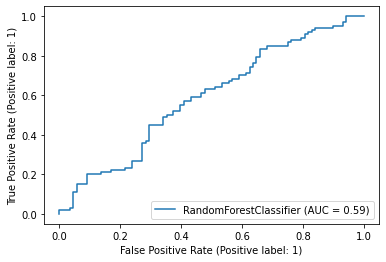

In [37]:
# predict labels with unseen dataset
prediction = forest.predict(X_test_filtered)

# print scores
print("Accuracy Score \t\t", accuracy_score(y_test , prediction))

# plot roc
sklearn.metrics.plot_roc_curve(forest, X_test_filtered, y_test)

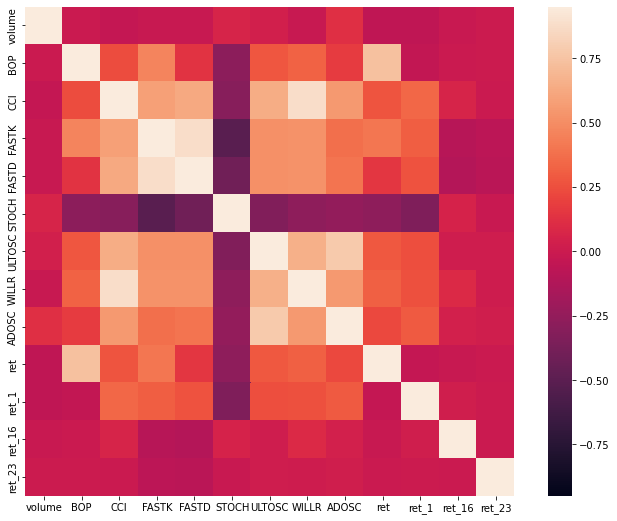

In [38]:
explore = pd.DataFrame(X_train_filtered, columns = list(feature_names[selected_rf_features['Ranking']==1]))
corrmat = explore.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmin = -.95, vmax = .95, square = True);

In [39]:
corrmat

,volume,BOP,CCI,FASTK,FASTD,STOCH,ULTOSC,WILLR,ADOSC,ret,ret_1,ret_16,ret_23
volume,1.000000,-0.002048,-0.033333,-0.019740,-0.017842,0.060515,0.030322,-0.018490,0.122422,-0.057898,-0.052129,-0.013827,0.003167
BOP,-0.002048,1.000000,0.238209,0.460906,0.139493,-0.281864,0.277883,0.320084,0.177661,0.737398,-0.041886,-0.005311,0.003481
CCI,-0.033333,0.238209,1.000000,0.582060,0.624982,-0.299703,0.641461,0.878493,0.551754,0.272632,0.347749,0.061812,-0.004804
FASTK,-0.019740,0.460906,0.582060,1.000000,0.883186,-0.508088,0.517046,0.520219,0.374754,0.406761,0.305890,-0.092030,-0.067435
FASTD,-0.017842,0.139493,0.624982,0.883186,1.000000,-0.403355,0.513462,0.522137,0.398413,0.149213,0.262140,-0.108034,-0.080733
STOCH,0.060515,-0.281864,-0.299703,-0.508088,-0.403355,1.000000,-0.329299,-0.272933,-0.251152,-0.267475,-0.340174,0.055129,-0.007727
ULTOSC,0.030322,0.277883,0.641461,0.517046,0.513462,-0.329299,1.000000,0.655509,0.782151,0.285160,0.245302,0.015428,0.015148
WILLR,-0.018490,0.320084,0.878493,0.520219,0.522137,-0.272933,0.655509,1.000000,0.551301,0.313743,0.254712,0.096391,0.008614
ADOSC,0.122422,0.177661,0.551754,0.374754,0.398413,-0.251152,0.782151,0.551301,1.000000,0.228950,0.291153,0.041661,0.022605
ret,-0.057898,0.737398,0.272632,0.406761,0.149213,-0.267475,0.285160,0.313743,0.228950,1.000000,-0.030216,-0.016248,-0.005302


##### Normalise Data

In [40]:
# perform normalization
#scaler = sklearn.preprocessing.MinMaxScaler()
scaler = sklearn.preprocessing.StandardScaler()
X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)

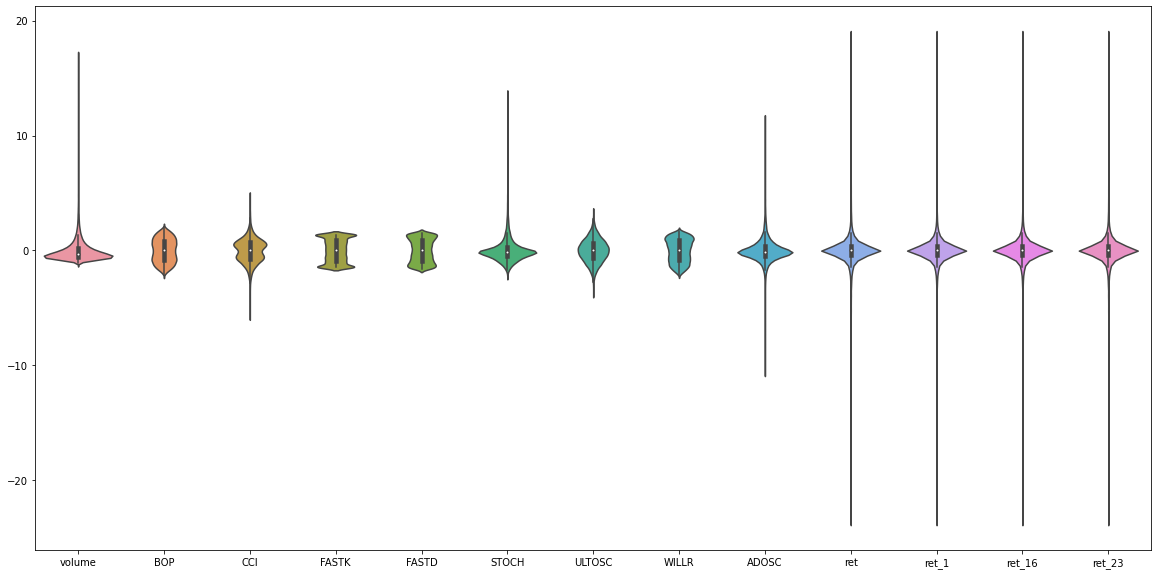

In [41]:
df_std = pd.DataFrame(X_train_filtered_scaled, columns = list(feature_names[selected_rf_features['Ranking']==1]))
plt.figure(figsize = (20,10))
sns.violinplot(data=df_std)
_ = ax.set_xticklabels(df_std.keys(), rotation=90)

In [43]:
df_std.describe()

,volume,BOP,CCI,FASTK,FASTD,STOCH,ULTOSC,WILLR,ADOSC,ret,ret_1,ret_16,ret_23
count,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04,1.834600e+04
mean,5.723767e-16,-3.389793e-17,2.623058e-17,-2.875711e-17,5.103903e-17,7.186857e-17,1.961801e-16,1.369412e-16,-2.813925e-16,1.407219e-17,3.140317e-17,-8.688557e-18,7.458573e-18
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00
min,-1.115749e+00,-2.126938e+00,-5.755491e+00,-1.447395e+00,-1.601436e+00,-2.231768e+00,-3.797674e+00,-2.108653e+00,-1.064919e+01,-2.362064e+01,-2.361968e+01,-2.362087e+01,-2.362160e+01
25%,-5.639416e-01,-8.334199e-01,-7.022180e-01,-9.304476e-01,-9.257371e-01,-5.236190e-01,-6.824896e-01,-8.470223e-01,-4.607840e-01,-3.638153e-01,-3.637777e-01,-3.635322e-01,-3.636036e-01
50%,-2.824057e-01,4.148750e-03,6.081008e-02,1.469851e-02,1.926659e-04,-1.395177e-01,9.668125e-03,7.616468e-02,-9.626610e-02,9.638241e-04,1.023547e-03,1.230048e-03,1.272497e-03
75%,2.077208e-01,8.408052e-01,6.959212e-01,9.401057e-01,9.399873e-01,2.763802e-01,6.877261e-01,8.872128e-01,3.572671e-01,3.810982e-01,3.811434e-01,3.814349e-01,3.813451e-01
max,1.699830e+01,2.047834e+00,4.773613e+00,1.387161e+00,1.534874e+00,1.365015e+01,3.395820e+00,1.698697e+00,1.149061e+01,1.881202e+01,1.881136e+01,1.881279e+01,1.881326e+01
